<a href="https://colab.research.google.com/github/deanhadzi/BGG_Ratings_Project/blob/master/BGG_Ratings_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Index of Libraries and Tools necessary to execute this notebook

In [1]:
!pip install --upgrade category_encoders
!pip install pandas-profiling==2.3.0
!pip install eli5

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('fivethirtyeight')

from scipy.stats import randint, uniform
import functools
import category_encoders as ce
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


Using TensorFlow backend.


### Initial Hypothesis

> Game mechanics, game category and game designer have a high impact on game ratings.

### Step 1 - Import dataframe and confirming it's shape and establish a baseline, run a quick **model**

#### Import dataframe

In [2]:
# Importing the dataframe.
# Original dataframe pulled from: https://www.kaggle.com/mrpantherson/board-game-data#bgg_db_2018_01.csv

bgg = pd.read_csv('https://raw.githubusercontent.com/deanhadzi/DSPT2_Project_2/master/data/bgg_db_2018_01.csv', encoding='latin_1')

# Getting a first view of the data.

bgg.head()

rank  ...  weight
0     1  ...  3.7720
1     2  ...  2.8056
2     3  ...  4.3538
3     4  ...  3.5446
4     5  ...  3.2465

[5 rows x 20 columns]

In [0]:
# Dropping the columns which we will not need for our exploration.

bgg = bgg.drop(columns=['bgg_url', 'image_url'])

# Checking the shape. Final dataframe should have 4999 observations and 18 features.

assert bgg.shape == (4999, 18)

#### Establish the baseline

In [4]:
# This is the baseline mean of our dataset. 
# As defined on BGG (https://boardgamegeek.com/wiki/page/ratings) 
# this rating is: Ok - will play if in the mood.

bgg['geek_rating'].mean()

6.082797089417868

#### Run initial model

* In this initial model we will use only numeric features

In [0]:
# Selecting only the numeric features.

bgg_initial = bgg.select_dtypes(include='number')

# Splitting the data to run the initial model.

X_train_initial, X_test_initial = train_test_split(bgg_initial, train_size=0.8, test_size=0.2, random_state=42)

In [0]:
# Defining our target.

target_initial = 'geek_rating'

y_train_initial = X_train_initial[target_initial]
X_train_initial = X_train_initial.drop(columns=target_initial)

y_test_initial = X_test_initial[target_initial]
X_test_initial = X_test_initial.drop(columns=target_initial)

In [7]:
# Running the model, obviously we have some data leakage so let's explore it further.

bgg_pipeline_initial = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

bgg_pipeline_initial.fit(X_train_initial, y_train_initial)

y_pred_initial = bgg_pipeline_initial.predict(X_test_initial)
score_initial = r2_score(y_test_initial, y_pred_initial)
print(f'Initial model r^2 score: {round(score_initial, 2)}')

Initial model r^2 score: 1.0


### Step 2 - Define the functions to speed up data wrangling

Our original dataframe has three features which contain long strings. These long strings list multiple mechanics, categories and designers. Following functions deal with separating those strings and encoding them in shape which we can use in our analysis. These particular features are the stars of our initial hypothesis.

In [0]:
def separate_string_features (df, target_feature):

# Creating the dataframe with strings from the named column,
# value after each comma is assigned to its own feature column within this new dataframe. 

    expanded_feature_df = df[target_feature].str.split(pat=',', expand=True)

# Stripping the strings in the expanded dataframe.

    expanded_feature_obj = expanded_feature_df.select_dtypes(['object'])
    expanded_feature_df[expanded_feature_obj.columns] = expanded_feature_df.apply(lambda x: x.str.strip())

# Combining all the values from the expanded dataframe in order to give them a total value count. 

    all_features_container = []

    for n in range(len(expanded_feature_df.columns)):
        column_content = expanded_feature_df.iloc[:, n].to_list()
        all_features_container.append(column_content)

    all_features_list = functools.reduce(lambda a, b: a + b, all_features_container)
    all_features_list = pd.Series(all_features_list)
    X = all_features_list

    return X, X.value_counts(normalize=True)

In [0]:
def keeping_top_rank(df, X, target_feature, target_rank):

    # Target rank number in function params define how many top ranked items
    # we wish to keep for our analysis.

    top_values = X.value_counts(normalize=True)[:target_rank].index.to_list()

    # Encoding the values.

    one_hots_feature = df[target_feature].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)

    # Creating the top rank dataframe.

    one_hots_feature_top = one_hots_feature[top_values]

    # Summing the remaining values into one number and putting it into one column.

    one_hots_other = one_hots_feature.drop(columns = top_values)
    one_hots_other[f'total other {target_feature}s'] = one_hots_other.sum(axis=1)
    one_hots_other = one_hots_other[f'total other {target_feature}s']

    # Combining the two dataframes.

    feature_final = pd.merge(one_hots_feature_top, one_hots_other,
                             left_index=True, right_index=True)
    
    return feature_final

### Step 3 - Wrangling the Mechanic, Category and Designer features

#### Step 3A - Separate string features into individual dataframes

In [0]:
# Wrangling our three string features. In this first substep we separate each string into its' 
# own columns.

mechanic_df, mechanic_value_counts = separate_string_features(bgg, 'mechanic')
category_df, category_value_counts = separate_string_features(bgg, 'category')
designer_df, designer_value_counts = separate_string_features(bgg, 'designer')

#### Step 3B - Checking the results of data wrangling

* Which top ranked values to keep?

Based on the personal domain knowledge I have decided to keep top 20 mechanics,
top 12 game categories and to create a feature which will denote if the game was designed by a proliffic designer or not.
Prolific designer is defined by frequency of games designed by particular individual. Using this metric we will pick top 20 designers, since their combined output comprise 13.61% of all top 5000 ranked games.

In [11]:
# Top values from the Mechanic feature. 

mechanic_value_counts[:30]

Dice Rolling                     0.097048
Hand Management                  0.093644
Variable Player Powers           0.060785
Set Collection                   0.052379
Area Control / Area Influence    0.044043
Card Drafting                    0.041820
Modular Board                    0.038555
Tile Placement                   0.036888
Hex-and-Counter                  0.033484
Action Point Allowance System    0.027232
Auction/Bidding                  0.026745
Simultaneous Action Selection    0.026676
Co-operative Play                0.024453
Area Movement                    0.023341
Worker Placement                 0.021952
Simulation                       0.021605
Grid Movement                    0.021257
Partnerships                     0.020354
Point to Point Movement          0.018965
Deck / Pool Building             0.018687
Route/Network Building           0.018062
Press Your Luck                  0.015353
Campaign / Battle Card Driven    0.013477
Pick-up and Deliver              0

In [12]:
# Top values from the Mechanic feature. 

category_value_counts[:30]

Card Game             0.101396
Wargame               0.069303
Fantasy               0.052489
Economic              0.040500
Fighting              0.038014
Science Fiction       0.033921
Dice                  0.025879
World War II          0.025002
Bluffing              0.024636
Medieval              0.024051
Miniatures            0.023394
Party Game            0.021858
Adventure             0.021639
Abstract Strategy     0.020981
Exploration           0.019592
Deduction             0.019446
Animals               0.018861
Ancient               0.018788
City Building         0.017764
Humor                 0.015937
Territory Building    0.014329
Nautical              0.014182
Action / Dexterity    0.013744
Negotiation           0.013744
Horror                0.012574
Political             0.012501
Civilization          0.012282
Real-time             0.011697
Racing                0.011624
Children's Game       0.011331
dtype: float64

In [13]:
# Top values from the Designer feature. 
# Game designed by the prolific designer will have value of 1. 
# Game not designed by the prolific designer will have value of 0.
# This feature will require some differnce in wrangling within step 3b.

designer_value_counts[:30]

Reiner Knizia            0.016739
(Uncredited)             0.009625
Wolfgang Kramer          0.008648
Martin Wallace           0.007532
Bruno Cathala            0.006277
Alan R. Moon             0.006138
Dean Essig               0.005719
Klaus Teuber             0.005580
Richard H. Berg          0.005440
Eric M. Lang             0.005440
Friedemann Friese        0.005301
none                     0.005022
Jr.                      0.005022
Michael Schacht          0.004882
Uwe Rosenberg            0.004603
Michael Kiesling         0.004324
Mark Herman              0.004324
Steve Jackson (I)        0.004185
Mike Elliott             0.004185
James Ernest             0.004185
Bruno Faidutti           0.003766
Stefan Dorra             0.003487
Stefan Feld              0.003487
Rob Daviau               0.003348
Klaus-Jürgen Wrede       0.003208
Leo Colovini             0.003069
Rüdiger Dorn             0.003069
Christian T. Petersen    0.003069
Seiji Kanai              0.003069
Tom Dalgliesh 

#### Step 3C - Keeping the top features from each column

In [0]:
# Finalizing our mechanic and category features.

mechanic_final = keeping_top_rank(bgg, mechanic_df, 'mechanic', 20)
category_final = keeping_top_rank(bgg, category_df, 'category', 12)

In [0]:
# Step 3B for the designer feature. Creating the list of top 20.

top_designer_values = designer_value_counts[:23].index.to_list()

# Top 20 has the following values which need to be removed. As individual designer can't be named.

unknown_designer = ['(Uncredited)', 'Jr.', 'none']

for ud in unknown_designer:
    top_designer_values.remove(ud)

# Finally encoding the designer feature.

one_hots_designer = bgg['designer'].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)

# Creating the designer dataframe.

one_hots_designer = one_hots_designer[top_designer_values]
one_hots_designer['top designer'] = one_hots_designer.sum(axis = 1)
designer_final = one_hots_designer['top designer']

#### Step 3D - Creating the final DataFrame for our analysis

In [0]:
# Dropping the features which we encoded manually.

bgg = bgg.drop(columns=['mechanic', 'category', 'designer'])

# Creating the list of the encoded dataframes and getting them ready for merge.

encoded_dfs = [bgg, mechanic_final, category_final, designer_final]

# Merging the and creating final dataframe.

bgg = functools.reduce(lambda left, right: pd.merge(left, right,
                                                    left_index=True, 
                                                    right_index=True), encoded_dfs)

### Step 4 - Final look at the Data before running the model

* Run Pandas Profile
* Drop features which we will not use



In [17]:
# View of the dataframe which will be featured in our anlysis.

bgg.head()

rank  game_id  ... total other categorys  top designer
0     1   174430  ...                     2             0
1     2   161936  ...                     2             0
2     3   182028  ...                     1             0
3     4    12333  ...                     2             0
4     5   167791  ...                     3             0

[5 rows x 50 columns]

In [18]:
# Running profile report.

bgg.profile_report()

In [0]:
# Following columns will be dropped:
# rank, game_id, names - drop reason high cardinality (each game has unique value).
# max_time and owned due to their high corellations to avg_time and num_votes.
# avg_rating - dropped to prevent data leakage as we are trying to predict geek_rating.

drop_columns = ['rank', 'game_id', 'names', 'max_time', 'owned', 'avg_rating']

# Dropping listed columns.

bgg = bgg.drop(columns = drop_columns)

# Creating the rollback copy of the dataframe in case we need to go back.

bgg_backup = bgg

### Step 5 - Running the model

#### Step 5A - Split the data

In [20]:
# Split the data into train+validation and test sets.

X_trainval, X_test = train_test_split(bgg, train_size=0.8, test_size=0.2,
                                      random_state=42)

X_trainval.shape, X_test.shape

((3999, 44), (1000, 44))

In [21]:
# Split the data into train and validation sets.

X_train, X_val = train_test_split(X_trainval, train_size=0.8, test_size=0.2,
                                      random_state=42)

X_train.shape, X_test.shape

((3199, 44), (1000, 44))

In [0]:
# Create y-target and X matrix which we will use to run our model.

target = 'geek_rating'

y_train = X_train[target]
X_train = X_train.drop(columns=target)

y_val = X_val[target]
X_val = X_val.drop(columns=target)

y_test = X_test[target]
X_test = X_test.drop(columns=target)

#### Step 5B - Create the pipeline and run the model

In [0]:
# The decision to run the RandomForestRegressor was based on the fact that it should be
# resilient to the scale. Since I ended up using only 11 features from the original dataset.

bgg_pipeline = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

In [24]:
# Fitting the model with our train data.

bgg_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         ve

In [25]:
# Calculating the R^2 score of the model. 

y_pred = bgg_pipeline.predict(X_val)
score = r2_score(y_val, y_pred)
print(f'Model r^2 score: {round(score, 2)}')

Model r^2 score: 0.89


In [26]:
# Calculating the R^2 score of the test data.

y_pred = bgg_pipeline.predict(X_test)
score = r2_score(y_test, y_pred)
print(f'Test r^2 score: {round(score, 2)}')

Test r^2 score: 0.89


#### Step 5C - Visualizations

With such high r^2 scores, let's run the feature importances to see if we still might have a data leakage issue.

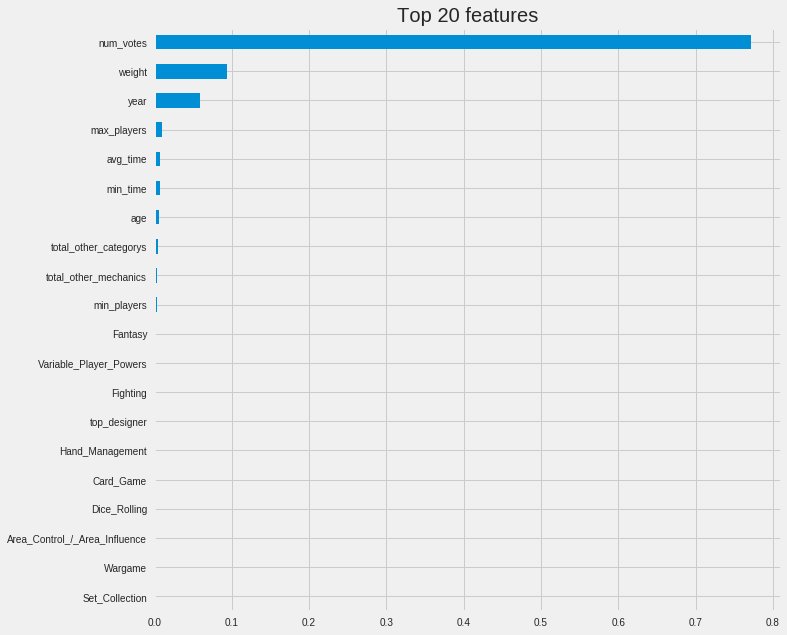

In [27]:
# Get feature importances

rf = bgg_pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances

n = 20
plt.figure(figsize=(10, 10))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [28]:
# Plotting the permutation importances in addition to feature importances.

transformers = make_pipeline(SimpleImputer())

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model, 
    scoring='r2',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names = feature_names)

Number of votes seems to be dominating. Both features and permutation importances seem to support that. My hypothesis was that game mechanics, game category and designer will have high impact on the game ratings. That seems not to be the case. Let's see correlation matrix between these features and our target.

In [0]:
# Create the dataframe with each feature and target and run the correlation matrix.

target = bgg_backup['geek_rating']

mechanic_target = pd.merge(mechanic_final, target, left_index=True, right_index=True)
category_target = pd.merge(category_final, target, left_index=True, right_index=True)
designer_target = pd.merge(designer_final, target, left_index=True, right_index=True)

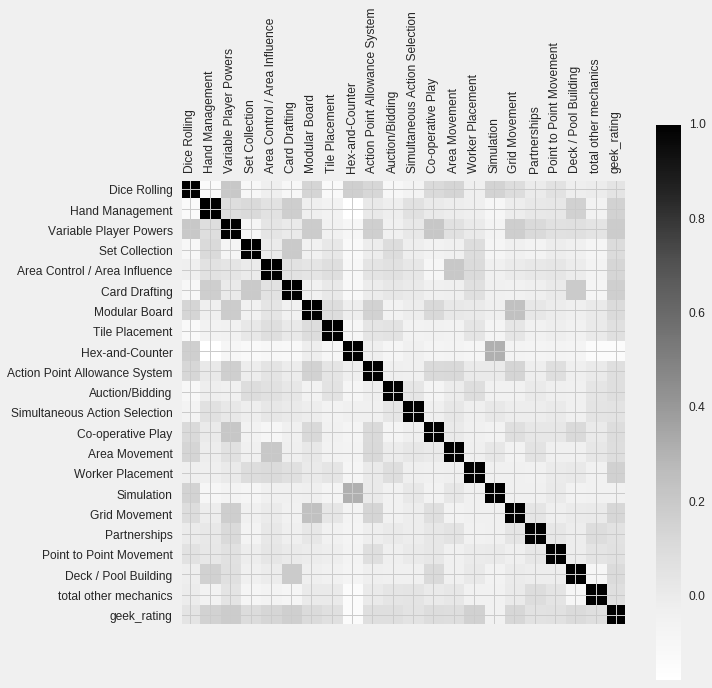

In [49]:
# Correlation matrix for game mechanics and our target. Results presented visually.

f = plt.figure(figsize=(10, 10))
plt.matshow(mechanic_target.corr(), fignum=f.number)
plt.xticks(range(mechanic_target.shape[1]), mechanic_target.columns, fontsize=12, rotation=90)
plt.yticks(range(mechanic_target.shape[1]), mechanic_target.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [31]:
# Actual values for the game mechanic correlation with target.

mechanic_target.corr().iloc[-1]

Dice Rolling                     0.041841
Hand Management                  0.147579
Variable Player Powers           0.178709
Set Collection                   0.091340
Area Control / Area Influence    0.127558
Card Drafting                    0.163767
Modular Board                    0.094904
Tile Placement                   0.062614
Hex-and-Counter                 -0.150630
Action Point Allowance System    0.074650
Auction/Bidding                  0.073498
Simultaneous Action Selection    0.047358
Co-operative Play                0.083406
Area Movement                    0.079130
Worker Placement                 0.150548
Simulation                      -0.046365
Grid Movement                    0.122353
Partnerships                     0.056190
Point to Point Movement          0.061263
Deck / Pool Building             0.095124
total other mechanics            0.072350
geek_rating                      1.000000
Name: geek_rating, dtype: float64

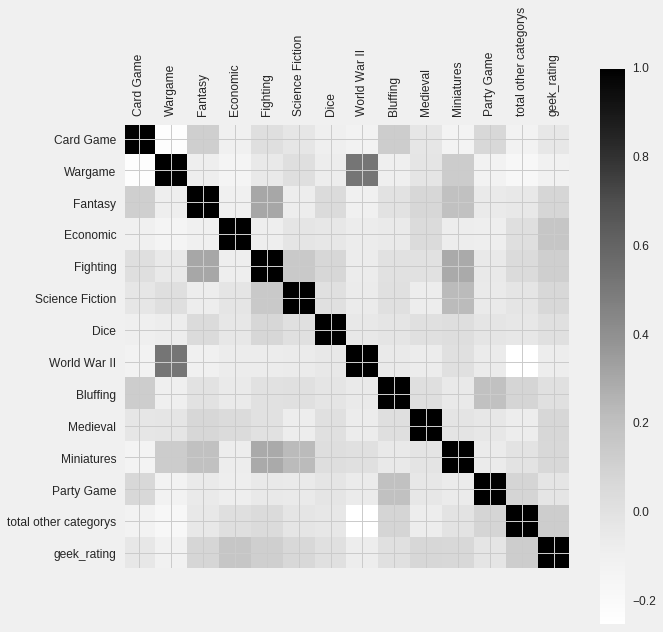

In [32]:
# Game category correlation with target.

f = plt.figure(figsize=(10, 10))
plt.matshow(category_target.corr(), fignum=f.number)
plt.xticks(range(category_target.shape[1]), category_target.columns, fontsize=12, rotation=90)
plt.yticks(range(category_target.shape[1]), category_target.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [33]:
# Actual numerical values of game category correlation.

category_target.corr().iloc[-1]

Card Game               -0.042436
Wargame                 -0.112111
Fantasy                  0.073297
Economic                 0.165442
Fighting                 0.108741
Science Fiction          0.062790
Dice                     0.008929
World War II            -0.081822
Bluffing                 0.008394
Medieval                 0.067113
Miniatures               0.059167
Party Game              -0.026555
total other categorys    0.122503
geek_rating              1.000000
Name: geek_rating, dtype: float64

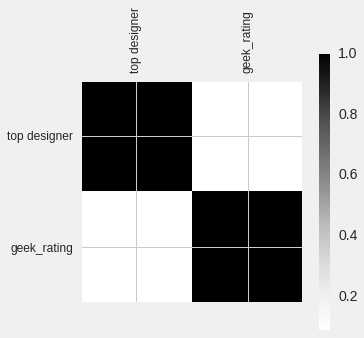

In [34]:
# Correlation matrix of designer and game rating.

f = plt.figure(figsize=(5, 5))
plt.matshow(designer_target.corr(), fignum=f.number)
plt.xticks(range(designer_target.shape[1]), designer_target.columns, fontsize=12, rotation=90)
plt.yticks(range(designer_target.shape[1]), designer_target.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [35]:
# Actual numerical value.

designer_target.corr().iloc[-1]

top designer    0.080829
geek_rating     1.000000
Name: geek_rating, dtype: float64

* It seems that game rating has a weak correlation with mechanics. 
* Most values fall between -.15 and .18
* Same can be said for the game categories. Correlation values are between -.11 to .17
* Finally designers correlate with the game rating at around .08

#### Step 5D - Running the model again, without the num_votes

In [0]:
# Dropping the number of votes in order to rerun the model. 

X_train = X_train.drop(columns=['num_votes'])

X_val = X_val.drop(columns=['num_votes'])

X_test = X_test.drop(columns=['num_votes'])

In [37]:
bgg_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         ve

In [38]:
# New r^2 score of our model.

y_pred = bgg_pipeline.predict(X_val)
score = r2_score(y_val, y_pred)
print(f'Model r^2 score: {round(score, 2)}')

Model r^2 score: 0.28


In [39]:
# Calculating the R^2 score of the test data.

y_pred = bgg_pipeline.predict(X_test)
score = r2_score(y_test, y_pred)
print(f'Test r^2 score: {round(score, 2)}')

Test r^2 score: 0.24


### Extra Step - trying to hypertune the model to get better results without using the number of votes.

In [40]:
# Setting ranges for our hyperparameters. 

param_distributions = {
    'randomforestregressor__n_estimators': randint(100, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__min_samples_split': randint(2, 20),
    'randomforestregressor__min_samples_leaf': randint(1, 10),
    'randomforestregressor__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    bgg_pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='r2', 
    verbose=10,
    random_state=42, 
    return_train_score=True, 
    n_jobs=-1
)

# Running the multiple folds of the data to find possible values.

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.1s finished


In [41]:
# Declaring the results of our parameters search.

print('Best hyperparameters', search.best_params_)
print('R^2 Score', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.450499251969543, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 188}
R^2 Score -0.23610463041044316


In [0]:
tuned_bgg_pipeline = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(n_estimators=188, max_depth=None,
                          max_features=0.450499251969543, 
                          min_samples_leaf=2,
                          min_samples_split=5, 
                          random_state=42, n_jobs=-1)
)

In [43]:
tuned_bgg_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None,
                                       max_features=0.450499251969543,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=2, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=188, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                

In [44]:
y_pred = tuned_bgg_pipeline.predict(X_val)
tuned_score = r2_score(y_val, y_pred)
print(f'Model r^2 score: {round(tuned_score, 2)}')

Model r^2 score: 0.29


Validation R^2 of hypertuned model increase by 0.01 from our original model which only relied on mechanics, categories and designer features.

In [45]:
y_pred = tuned_bgg_pipeline.predict(X_test)
tuned_score = r2_score(y_test, y_pred)
print(f'Test r^2 score: {round(tuned_score, 2)}')

Test r^2 score: 0.23


Test R^2 of hypertuned model decreases by 0.01 from our original model which only relied on mechanics, categories and designer features.

### Conclusion

> Our initial hypothesis seems to be wrong. Mechanics, game category and designer are only accounting for around small portion of game popularity. My conclusion is that, if you are able to have enough people buy the game, there is a good chance it will end up being popular.